## E.004: Investigation of a simplified model for Urugua

In [1]:
import pypsa

import matplotlib.pyplot as plt
import pandas as pd

## Read data

In [2]:
input_fls = {
    "load": "../data/uy_load.csv",
    "hydro": "../data/uy_hydro.csv", 
    "hydro_2023": "../data/uy_hydro_2023.csv",
    "wind": "../data/uy_wind.csv", 
    "wind_2023": "../data/uy_wind_2023.csv"
}

In [3]:
def read_df(inpit_fl):
    data_df = pd.read_csv(inpit_fl)
    data_df["snapshot"] = pd.to_datetime(data_df["snapshot"])
    return data_df

In [4]:
load_df = read_df(input_fls["load"])

hydro_df = read_df(input_fls["hydro"])
wind_df = read_df(input_fls["wind"])

hydro_2023_df = read_df(input_fls["hydro_2023"])
wind_2023_df = read_df(input_fls["wind_2023"])

## Explore inputs

### Wind

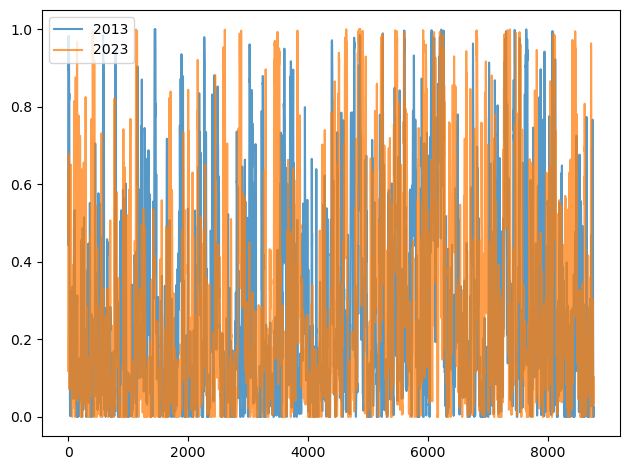

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)
wind_df[["onwind"]].plot(ax=ax, alpha=0.75)
wind_2023_df[["onwind"]].plot(ax=ax, alpha=0.75)
plt.legend(["2013", "2023"], loc="best")
plt.tight_layout()

In [6]:
# wind potential, a share of the maximum
print(
    round(wind_df["onwind"].mean(), 2),
    round(wind_2023_df["onwind"].mean(), 2)
)

0.26 0.28


### Hydro

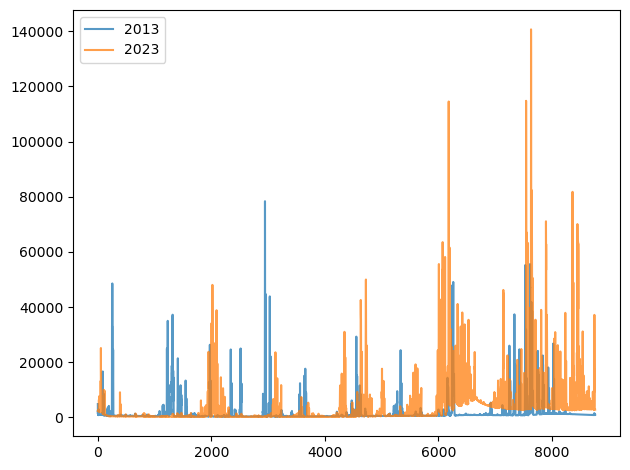

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
hydro_df["hydro"].plot(ax=ax, alpha=0.75)
hydro_2023_df["hydro"].plot(ax=ax, alpha=0.75)
plt.legend(["2013", "2023"], loc="best")
plt.tight_layout()

In [8]:
# hydro potential [MW]
print(
    round(hydro_df["hydro"].mean(), 2),
    round(hydro_2023_df["hydro"].mean(), 2)
)

1578.31 3764.93


In [9]:
# hydro potential [MW]
print(
    round(hydro_df["hydro"][0:2000].mean(), 2),
    round(hydro_2023_df["hydro"][0:2000].mean(), 2)
)

1509.83 700.39


## Build the model

In [10]:
def build_power_model(
        load_df,
        wind_ts,
        hydro_ts,
    ):
    network = pypsa.Network(snapshots = load_df.index)
    network.add("Bus", "B1")

    network.add("Generator", "Wind",
                carrier = "wind",
                bus="B1",
                capital_cost = 35_000,
                p_nom_max = 6_000,
                p_max_pu = wind_ts,
                p_nom_extendable = True,
                )

    # a fake generator which represents unserved energy 
    network.add("Generator", "LoadShedding",
                carrier = "shedding",
                bus="B1",
                capital_cost = 0,
                marginal_cost = 100_000,
                p_nom_extendable = True)

    network.add("StorageUnit", "Hydro",
                bus="B1",
                max_hours = 24 * 14,
                p_max_pu=1.0,  # dispatch
                p_min_pu=0.0,  # store
                p_nom = 2_000,
                inflow = hydro_ts,       
                p_nom_extendable = False,
                efficiency_dispatch=0.9,
                efficiency_store=0.0,
                cyclic_state_of_charge=True)

    network.add("Load", "L1",
                bus="B1",
                p_set=load_df["load"])
    return network

In [11]:
model_2013 = build_power_model(
    load_df=load_df,
    wind_ts=wind_df["onwind"],
    hydro_ts=hydro_df["hydro"]
)
model_2023 = build_power_model(
    load_df=load_df,
    wind_ts=wind_2023_df["onwind"],
    hydro_ts=hydro_2023_df["hydro"]
)

### Optimisation runs

In [13]:
model_2013.optimize()

Index(['Wind', 'LoadShedding'], dtype='object', name='Generator')
Index(['B1'], dtype='object', name='Bus')
Index(['Wind', 'LoadShedding'], dtype='object', name='Generator')
Index(['B1'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 59.39it/s]
INFO:linopy.io: Writing time: 0.61s
INFO:linopy.solvers:Log file at C:\Users\matte\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52562 primals, 105123 duals
Objective: 3.84e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_c

('ok', 'optimal')

In [14]:
model_2023.optimize()

Index(['Wind', 'LoadShedding'], dtype='object', name='Generator')
Index(['B1'], dtype='object', name='Bus')
Index(['Wind', 'LoadShedding'], dtype='object', name='Generator')
Index(['B1'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 56.89it/s]
INFO:linopy.io: Writing time: 0.63s
INFO:linopy.solvers:Log file at C:\Users\matte\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52562 primals, 105123 duals
Objective: 1.05e+11
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_c

('ok', 'optimal')

## Optimisation results

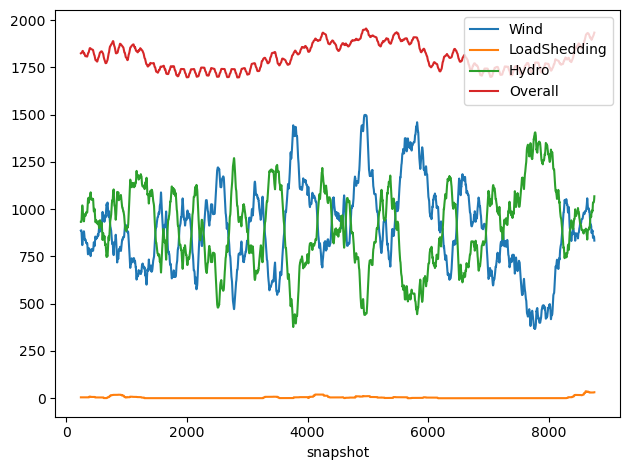

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
model_2013.generators_t.p[["Wind", "LoadShedding"]].rolling(240).mean().plot(ax=ax)
model_2013.storage_units_t.p.rolling(240).mean().plot(ax=ax)
model_2013.loads_t.p_set["L1"].rolling(240).mean().plot(ax=ax)

plt.legend(["Wind", "LoadShedding", "Hydro", "Overall", "Load"], loc="best")
plt.tight_layout()

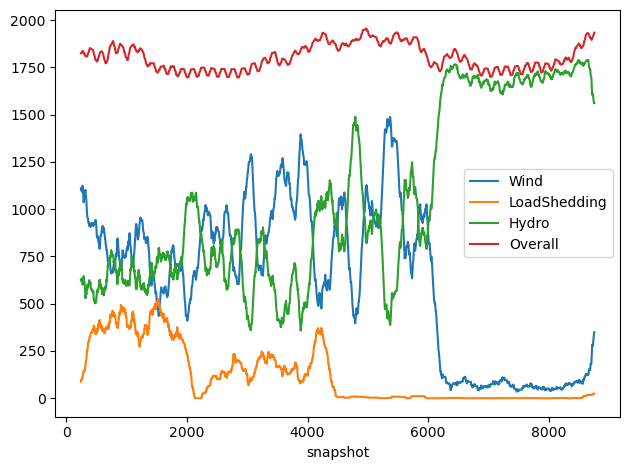

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1)
model_2023.generators_t.p[["Wind", "LoadShedding"]].rolling(240).mean().plot(ax=ax)
model_2023.storage_units_t.p.rolling(240).mean().plot(ax=ax)
model_2023.loads_t.p_set["L1"].rolling(240).mean().plot(ax=ax)

plt.legend(["Wind", "LoadShedding", "Hydro", "Overall", "Load"], loc="best")
plt.tight_layout()

In [16]:
print(
    round(model_2013.generators_t.p[["LoadShedding"]].sum().sum() / 1e6, 2),
    round(model_2023.generators_t.p[["LoadShedding"]].sum().sum() / 1e6, 2)
)

0.04 1.04
